# Visual Object Tracking employed by Deep Learning: Automatic License Plate Recognition

The source of inspiration and the dataset for this code are derived from https://www.kaggle.com/code/sarthakvajpayee/license-plate-recognition-using-cnn

The image used for testing is sourced from https://vinodpatildev.medium.com/deep-learning-cnn-model-to-auto-detect-vehicles-number-plate-using-python-and-api-195a773a90e4

## Importing the Libraries

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout

## Setting the Path to Datasets

In [2]:
training_set = r'Path\ALPR\data\train'
testing_set = r'Path\ALPR\data\test'

## Data required for detecting Lisence Plate

This cascade classifier is designed to recognize areas within an image that exhibit characteristics similar to Indian license plates.

In [3]:
# Loads the necessary data for license plate detection from the cascade classifier

plate_cascade = cv2.CascadeClassifier(r'Path\ALPR\indian_license_plate.xml')

## Detecting of License Plate

The "detect_license_plate" function identifies the numbers or letters on vehicle license plates, and it additionally outlines the recognized plate with a rectangular box.

## Input Shape

In [4]:
def detect_license_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img,
                                                scaleFactor = 1.2,
                                                minNeighbors = 7
                                               ) 
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] 
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img,
                      (x+2,y),
                      (x+w-3, y+h-5),
                      (0, 255, 0), 3
                     ) 
    if text!='':
        plate_img = cv2.putText(plate_img,
                                text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                0.5, (0, 255, 0), 1,
                                cv2.LINE_AA
                               )
        
    return plate_img, plate

## Display Image Function

The method "display" is invoked to showcase an image with a highlighted rectangle, indicating the detected area where the license plate is located.

In [5]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

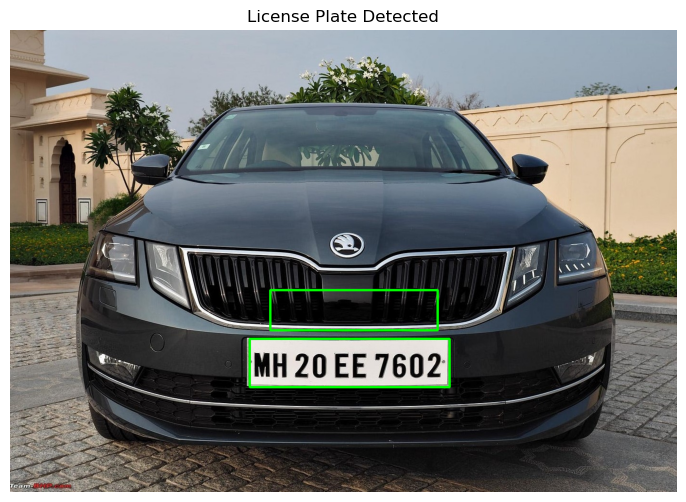

In [6]:
img = cv2.imread(r'Path\ALPR\car4.jpg')
output_img, plate = detect_license_plate(img)
display(output_img, 'License Plate Detected')

## Displaying the Extracted Image

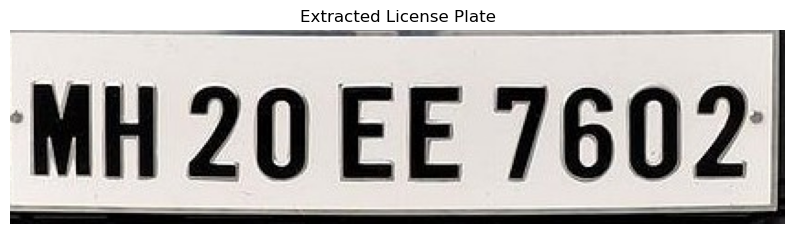

In [7]:
display(plate, 'Extracted License Plate')

## Extracting Characters

This processes contours within an image to identify and extract character-like regions based on specified dimensions.

In [8]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) 
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

## Segmenting Characters

In [9]:
def segment_characters(image) :
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

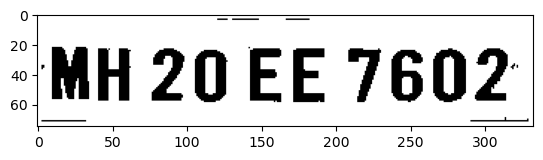

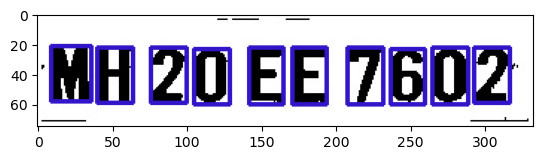

In [10]:
char = segment_characters(plate)

## Displaying Individual Characters

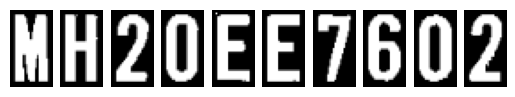

In [11]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap = 'gray')
    plt.axis('off')

## Building the CNN Architecture

After extracting individual letters from license plates as images, we proceed to create and train a Convolutional Neural Network (CNN) using a comprehensive dataset that includes various types of numbers. Subsequently, we employ a for loop to sequentially input the trained model with the extracted individual images (comprising letters and numbers). This iterative process enables the detection of letters, figures, and numbers on license plates, culminating in an effective number plate recognition system.

### Initialization of CNN

In [12]:
# The images are resized to a dimension of 28x28 pixels, considering they predominantly feature numerical figures.

input_shape = (28, 28, 3)
ALPR = tf.keras.models.Sequential()

### CNN part of the Code

In [13]:
ALPR.add(Conv2D(16, (22,22), input_shape = input_shape, activation='relu', padding='same'))
ALPR.add(Conv2D(32, (16,16), input_shape = input_shape, activation='relu', padding='same'))

ALPR.add(Conv2D(64, (8,8), input_shape = input_shape, activation='relu', padding='same'))
ALPR.add(Conv2D(64, (4,4), input_shape = input_shape, activation='relu', padding='same'))

ALPR.add(MaxPooling2D(pool_size=(4, 4)))
ALPR.add(Dropout(0.4))

### Flattening Layer

In [14]:
ALPR.add(Flatten())

### ANN Architecture

In [15]:
ALPR.add(Dense(128, activation='relu'))
ALPR.add(Dense(36, activation='softmax'))
ALPR.compile(loss ='sparse_categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

### Model Summary

In [16]:
ALPR.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

## Data Augmentation

These generators are used to preprocess and augment image data on-the-fly during model training. The training images are augmented with random shifts, and both training and testing images are scaled to the range [0, 1]. These generators are then used to provide batches of preprocessed images and corresponding labels for model training and evaluation.

In [17]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1
                                         )

In [18]:
training_images = train_data_generator.flow_from_directory(training_set,
                                                           batch_size = 1,
                                                           target_size = (28,28),
                                                           class_mode = 'sparse'
                                                          )

Found 864 images belonging to 36 classes.


In [19]:
testing_images = train_data_generator.flow_from_directory(testing_set,
                                                          target_size = (28,28),
                                                          class_mode = 'sparse'
                                                          )

Found 216 images belonging to 36 classes.


## Custom Call Back Function

The "callback" method is activated when the model's accuracy reached to 0.99.

In [20]:
class StopTrainingOnAccuracy(Callback):
    def __init__(self, target_accuracy = 0.99):
        super(StopTrainingOnAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print("\n")
            print(f"\nStopping training as validation accuracy reached {val_accuracy:.4f} >= {self.target_accuracy}")
            self.model.stop_training = True
            
stop_on_accuracy_callback = StopTrainingOnAccuracy(target_accuracy = 0.99)

## Training the Model

It trains the neural network model (ALPR) on the provided training data (training_images) for 40 epochs. The model's performance is monitored on the validation data (testing_images). The training process will stop early if the specified accuracy threshold is achieved, as indicated by the provided callback.

I opted for a batch size of 1 because when using a batch size of 32 for instance, the model showed minimal improvement, with the accuracy remaining consistent.

In [21]:
ALPR.fit(training_images,
         steps_per_epoch = len(training_images),
         validation_data = testing_images, 
         epochs = 40,
         callbacks = [stop_on_accuracy_callback])

Epoch 1/40


864/864 [==============================] - 29s 31ms/step - loss: 3.1594 - accuracy: 0.1296 - val_loss: 1.9047 - val_accuracy: 0.4167
Epoch 2/40
864/864 [==============================] - 27s 31ms/step - loss: 1.2950 - accuracy: 0.6169 - val_loss: 0.6580 - val_accuracy: 0.8426
Epoch 3/40
864/864 [==============================] - 28s 32ms/step - loss: 0.5714 - accuracy: 0.8310 - val_loss: 0.5349 - val_accuracy: 0.7963
Epoch 4/40
864/864 [==============================] - 28s 32ms/step - loss: 0.4294 - accuracy: 0.8669 - val_loss: 0.2747 - val_accuracy: 0.9259
Epoch 5/40
864/864 [==============================] - 28s 32ms/step - loss: 0.3262 - accuracy: 0.8958 - val_loss: 0.4142 - val_accuracy: 0.9028
Epoch 6/40
864/864 [==============================] - 26s 30ms/step - loss: 0.2355 - accuracy: 0.9294 - val_loss: 0.1816 - val_accuracy: 0.9491
Epoch 7/40
864/864 [==============================] - 26s 31ms/step - loss: 0.1910 - accuracy: 0.9340 - val_loss: 0.0705 - val_accurac

## Predicting

The provided code includes a function, fix_dimension, which standardizes the dimensions of an input image to 28x28x3. Another function, show_results, processes a list of character images by resizing them and using a pre-trained neural network model (ALPR) to predict the characters. The predicted characters are assembled into a reconstructed plate number based on the highest probabilities for each class. Finally, calling print(show_results()) outputs the reconstructed plate number.

In [22]:
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c
    output = []
    for i, ch in enumerate(char):  
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3) 
        y_probs = ALPR.predict(img)[0]  
        y_ = np.argmax(y_probs)  
        character = dic[y_]
        output.append(character)  
    plate_number = ''.join(output)
    return plate_number

print("\nPredicted number on the license plate:", show_results())

1/1 [==============================] - 0s 63ms/step

Predicted number on the license plate: MH20EE7602
